In [86]:
import os
import sys
import ast
from pprint import pprint
import pandas as pd
import matplotlib.pylab as plt
import matplotlib
import numpy as np
import datetime as dt
%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度

def set_data(df, mode='pcap', tz=0):
    if mode == 'pcap':
        df['seq'] = df['seq'].astype('Int32')
        # df['rpkg'] = df['rpkg'].astype('Int8')
        df['frame_id'] = df['frame_id'].astype('Int32')
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['xmit_time'] = pd.to_datetime(df['xmit_time'])
        df['arr_time'] = pd.to_datetime(df['arr_time'])
        df['Timestamp_epoch'] = df['Timestamp_epoch'].astype('float32')
        df['xmit_time_epoch'] = df['xmit_time_epoch'].astype('float32')
        df['arr_time_epoch'] = df['arr_time_epoch'].astype('float32')
        df['lost'] = df['lost'].astype('boolean')
        df['excl'] = df['excl'].astype('boolean')
        df['latency'] = df['latency'].astype('float32')
    # E-UTRA & NR
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    if mode == 'lte':
        df = df.rename(columns={
            'RSRP(dBm)': 'RSRP',
            'RSRQ(dB)': 'RSRQ',
            'Serving Cell Index': 'serv_cel_index',
            'Number of Neighbor Cells': 'num_neigh_cels',
            'Number of Detected Cells': 'num_cels',
            }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                        'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                        *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
        df.loc[df['serv_cel_index'] == '(MI)Unknown', 'serv_cel_index'] = '3_SCell'
        df['num_cels'] = df['num_neigh_cels'] + 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    if mode == 'nr':
        if df.empty:
            df = pd.DataFrame(columns=['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                                       'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0'])
        else:
            df = df.rename(columns={
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
                }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                            'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                            *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
            df.loc[df['serv_cel_pos'] != 255, 'serv_cel_index'] = 'PSCell'
            df[['PCI','RSRP','RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df.loc[df['serv_cel_pos'] == 255, 'num_neigh_cels'] = df['num_cels']
            df.loc[df['serv_cel_pos'] != 255, 'num_neigh_cels'] = df['num_cels'] - 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    return df

In [87]:
# root = '/home/wmnlab/D/database'
root = '/Users/jackbedford/Desktop/MOXA/Code/data'
paths = [s for s in os.listdir(root) if s.startswith('202') and os.path.isdir(os.path.join(root, s))]

md_files = []

for date_dir in paths:
    datedir = os.path.join(root, date_dir)
    md_file = [os.path.join(datedir, s) for s in os.listdir(datedir) if s.endswith('.md')]
    md_files += md_file

md_files = sorted(md_files)

# Select dates
# md_files = md_files[:-1]
# md_files = [md_files[2]]
md_files = [s for s in md_files if '05-04' not in s and '05-07' not in s]

pprint(md_files)

['/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/2023-03-16.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-26/2023-03-26.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/2023-04-01.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/2023-04-10.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-17/2023-04-17.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-15/2023-05-15.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-24/2023-05-24.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-26/2023-05-26.md']


In [88]:
class Experiment():
    
    def __init__(self, dir_name, setting):
        
        self.dir_name = dir_name
        self.setting = setting
        
    def __repr__(self):
        return f'{self.dir_name} -> {self.setting}'

exp_list = []

for md_file in md_files:
    
    md_f = open(md_file, 'r')
    lines = []
    l = md_f.readline()[:-1]
    
    while l:
        
        if l == '#endif':
            break
        lines.append(l)
        l = md_f.readline()[:-1]
        
    md_f.close()
    
    for exp, dic in zip(lines[::2], lines[1::2]):
        
        dictionary = ast.literal_eval(dic)
        parent_dir = os.path.dirname(md_file)
        experiment = Experiment(dir_name = os.path.join(parent_dir, exp), setting=dictionary)
        exp_list.append(experiment)
        
pprint(exp_list)

[/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q -> {'qc00': 'B1', 'qc02': 'B7', 'qc03': 'B8'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-26/Bandlock_Udp_All_RM500Q -> {'qc00': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q -> {'qc00': 'B1B3', 'qc01': 'B1B8', 'qc02': 'LTE', 'qc03': 'All'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_B1_B3_B7_B8_RM500Q -> {'qc00': 'B1', 'qc01': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment1 -> {'qc00': 'All', 'qc01': 'All', 'qc02': 'All', 'qc03': 'All'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment2 -> {'qc00': 'B1', 'qc01': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment3 -> {'qc00': 'LTE', 'qc01': 'All', 'qc02': 'B7B8', 'qc03': 'B7'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023

In [89]:
# Set band parameters
schms = ['All','LTE','B1','B3','B7','B8','B1B3','B1B7','B1B8','B3B7','B3B8','B7B8','B3B7B8']

rrc_dict = {}
nr_dict = {}
lte_dict = {}
ul_pkt_dict = {}
dl_pkt_dict = {}

for schm in schms:
        
    path_list = []
    
    for exp in exp_list:
        
        reverse_dict = {v:k for k, v in exp.setting.items()}
        
        try:
            dev = reverse_dict[schm]
        except:
            # print('warning:', schm)
            continue
        
        device_dir = os.path.join(exp.dir_name, dev)
        
        for trace in os.listdir(device_dir):
        
            if '#' not in trace:
                continue
        
            trace_dir = os.path.join(device_dir, trace, 'data')
            path_list.append(trace_dir)

    path_list = sorted(path_list)

    rrc_list, nr_list, lte_list, ul_pkt_list, dl_pkt_list = [], [], [], [], []

    for path in path_list:
        
        rrc_list += [os.path.join(path, s) for s in os.listdir(path) if s.endswith('_rrc.pkl')]
        nr_list += [os.path.join(path, s) for s in os.listdir(path) if s.endswith('_nr_ml1.pkl')]
        lte_list += [os.path.join(path, s) for s in os.listdir(path) if s.endswith('_ml1.pkl') and not s.endswith('_nr_ml1.pkl')]
        ul_pkt_list += [os.path.join(path, 'udp_uplk_loss_latency.pkl')]
        dl_pkt_list += [os.path.join(path, 'udp_dnlk_loss_latency.pkl')]
    
    rrc_dict[schm] = rrc_list
    nr_dict[schm] = nr_list
    lte_dict[schm] = lte_list
    ul_pkt_dict[schm] = ul_pkt_list
    dl_pkt_dict[schm] = dl_pkt_list

In [90]:
rrc_dict['All'] = rrc_dict['All'] + rrc_dict['B3B7B8']
nr_dict['All'] = nr_dict['All'] + nr_dict['B3B7B8']
lte_dict['All'] = lte_dict['All'] + lte_dict['B3B7B8']
ul_pkt_dict['All'] = ul_pkt_dict['All'] + ul_pkt_dict['B3B7B8']
dl_pkt_dict['All'] = dl_pkt_dict['All'] + dl_pkt_dict['B3B7B8']

schms.remove('B3B7B8')

del rrc_dict['B3B7B8']
del nr_dict['B3B7B8']
del lte_dict['B3B7B8']
del ul_pkt_dict['B3B7B8']
del dl_pkt_dict['B3B7B8']

In [91]:
rrc_dict['All']

['/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#01/data/diag_log_qc03_2023-04-01_15-21-12_rrc.pkl',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#02/data/diag_log_qc03_2023-04-01_15-30-33_rrc.pkl',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#03/data/diag_log_qc03_2023-04-01_15-37-38_rrc.pkl',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#04/data/diag_log_qc03_2023-04-01_15-51-06_rrc.pkl',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment1/qc03/#01/data/diag_log_qc03_2023-04-10_15-05-44_rrc.pkl',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment1/qc03/#02/data/diag_log_qc03_2023-04-10_15-19-16_rrc.pkl',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment3/qc01/#01/data/diag_log_qc01_2023-04-10_16-29-38_rrc.pkl',
 '/Users/jackbedford/

## Boxplot

### plot dl plr

In [17]:
# Downlink
DD = {key: [0, []] for key in schms}

for schm in schms:

    dl_files = dl_pkt_dict[schm]

    for dl_file in dl_files:

        df_dl = pd.read_pickle(dl_file)
        df_dl = set_data(df_dl)
        dlplr = df_dl.lost.mean() * 100
        
        print(round(dlplr, 2))
        
        DD[schm][0] += 1
        DD[schm][1].append(dlplr)

0.3
0.42
0.52
0.49
1.01
0.13
0.22
1.94
1.69
1.79
0.32
1.59
0.14
1.79
0.49
0.93
0.14
0.98
0.8
0.27
0.15
0.53
1.09
0.7
0.76
1.67
0.57
1.54
0.87
0.48
1.55
0.52
1.54
0.53
0.38
2.23
0.28
0.4
0.1
1.15
0.3
0.35
0.82
1.16
0.15
1.11
0.26
1.15
0.36
0.25
0.0
0.14
0.0
0.0
0.0
0.11
0.96
0.4
0.12
0.66
0.0
0.74
1.02
1.89
0.01
0.0
0.0
0.0
0.0
0.6
0.0
0.77
0.0
0.11
0.0
0.0
0.05
0.11
0.0
0.36
0.03
0.0
0.0
1.17
0.0
0.47
0.07
0.83
0.0
0.04
0.0
0.0
0.0
0.09
0.06
0.1
0.0
0.39
0.02
0.0
0.0
0.0
0.0
0.0
0.0
0.51
0.65
0.96
0.0
0.52
0.0
0.76
0.0
0.98
0.0
1.02
0.1
0.68
0.0
0.45
0.78
0.57
1.07
1.17
0.12
0.86
0.04
1.4
1.93
0.68
0.63
0.41
0.34
1.16
0.89
1.3
0.3
1.95
1.03
0.69
0.52
0.93
0.14
0.38
0.2
0.97
0.69
1.53
0.22
1.14
0.45
0.61
0.23
1.98
0.97
0.48
0.15
2.21
1.04
1.2
1.72
1.27
0.65
1.98
1.08
2.28
2.67
1.65
0.91
1.54
0.67
1.3
0.41
0.78
0.9
1.32
0.96
1.76
1.72
2.16
0.18
2.0
0.58
2.69
0.65
1.08
0.7
0.81
1.36
1.57
0.22
1.61
0.25
1.44
0.88
3.08
0.63
0.56
0.43
0.17
0.39
0.77
0.37
1.27
2.3
0.46
0.94
0.19
0.1
0.35
1.04

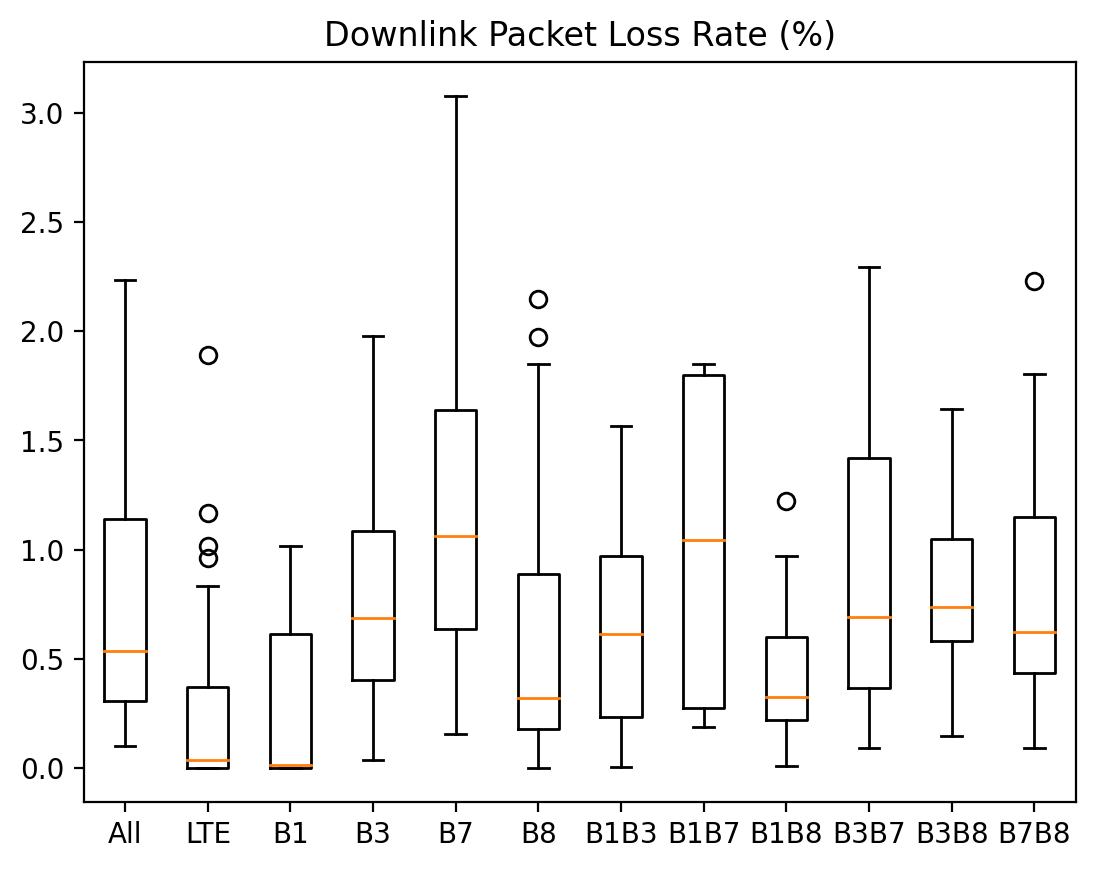

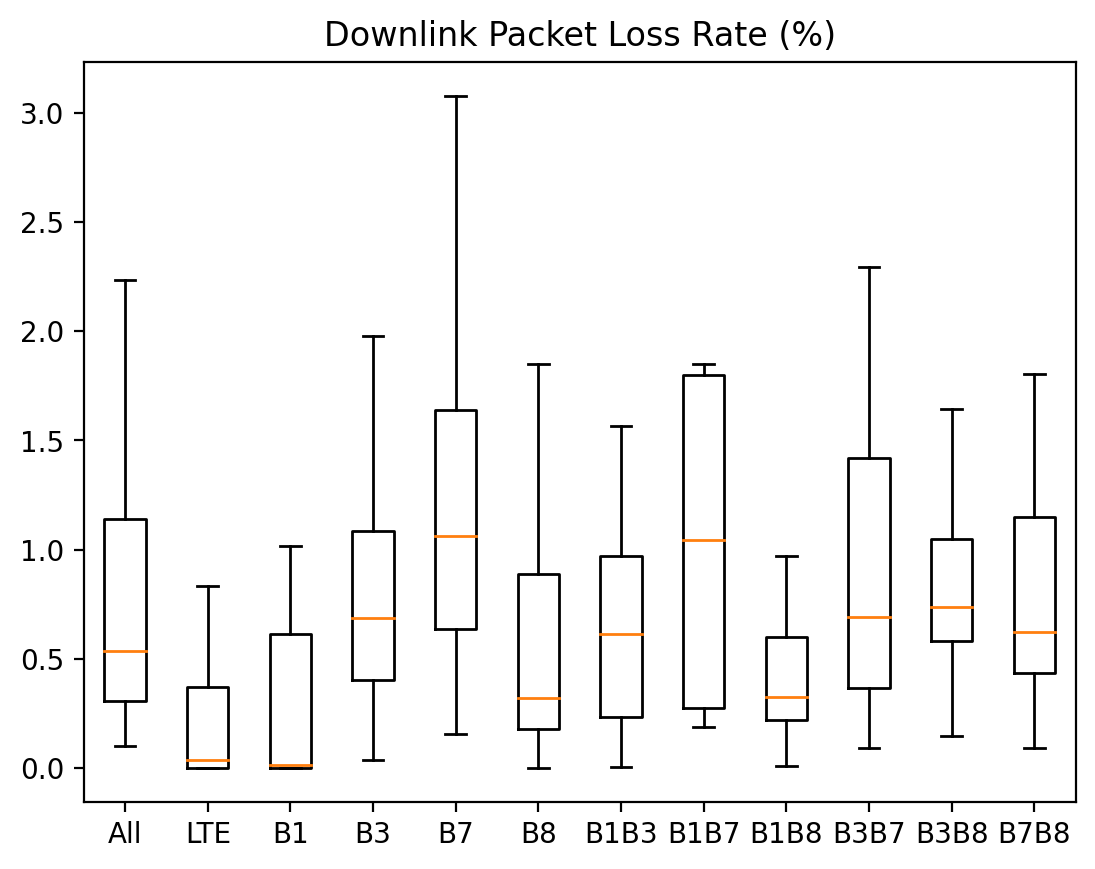

In [18]:
boxes = [DD[schm][1] for schm in schms]
labels = schms
plt.figure()
plt.boxplot(boxes, labels=labels, showfliers=True)
plt.title('Downlink Packet Loss Rate (%)')
plt.savefig(os.path.join('./temp', f'dl_plr_boxplot.png'), bbox_inches='tight', dpi=300)
plt.show()

boxes = [DD[schm][1] for schm in schms]
labels = schms
plt.figure()
plt.boxplot(boxes, labels=labels, showfliers=False)
plt.title('Downlink Packet Loss Rate (%)')
plt.savefig(os.path.join('./temp', f'dl_plr_boxplot_wo_outliers.png'), bbox_inches='tight', dpi=300)
plt.show()

### plot ul plr

In [19]:
# Uplink
DD = {key: [0, []] for key in schms}

for schm in schms:

    ul_files = ul_pkt_dict[schm]

    for ul_file in ul_files:

        df_ul = pd.read_pickle(ul_file)
        df_ul = set_data(df_ul)
        ulplr = df_ul.lost.mean() * 100
        
        print(round(ulplr, 2))
        
        DD[schm][0] += 1
        DD[schm][1].append(ulplr)

0.04
0.1
0.03
0.02
0.56
0.13
0.02
0.15
0.11
0.85
0.04
0.26
0.07
0.19
0.17
0.04
0.03
0.02
0.09
0.03
0.03
0.07
0.07
0.02
0.02
0.04
0.05
0.06
0.08
0.02
0.14
0.07
3.2
0.11
2.71
0.43
2.75
0.04
0.11
2.8
0.01
0.11
0.12
0.03
0.03
0.06
0.02
0.36
0.12
0.03
0.01
0.01
0.0
0.01
0.0
0.01
0.0
0.01
0.01
0.01
0.01
0.05
2.96
0.0
0.0
2.7
0.01
0.01
0.03
0.01
0.01
0.13
0.02
0.01
0.03
2.68
0.0
0.01
0.0
0.01
0.01
0.01
0.01
0.47
0.0
0.01
0.0
0.01
0.0
0.01
0.01
0.01
0.01
0.38
0.01
0.36
0.01
0.01
0.01
0.01
0.0
0.0
0.0
0.01
0.0
0.0
0.0
0.0
0.0
0.0
0.01
0.02
0.0
0.0
0.0
0.01
0.01
0.02
0.0
0.08
0.01
0.17
0.21
0.03
0.02
2.89
0.02
0.06
0.08
0.02
0.14
2.86
0.02
0.08
0.06
0.03
0.06
0.1
0.03
0.05
0.11
0.1
0.09
0.02
0.07
0.26
0.02
0.07
0.02
0.08
0.03
0.04
0.03
0.11
0.05
0.09
0.03
0.23
0.03
0.13
0.09
0.03
0.04
0.66
0.08
0.35
0.08
0.49
0.19
0.13
0.08
0.03
0.02
0.03
0.03
0.09
0.04
0.13
0.14
0.1
0.06
0.07
0.05
0.4
0.08
0.08
0.19
0.48
0.1
0.52
0.16
0.22
0.13
0.03
0.02
0.03
0.03
0.1
0.1
0.02
0.13
0.04
0.06
0.12
0.53
0.07
0.03

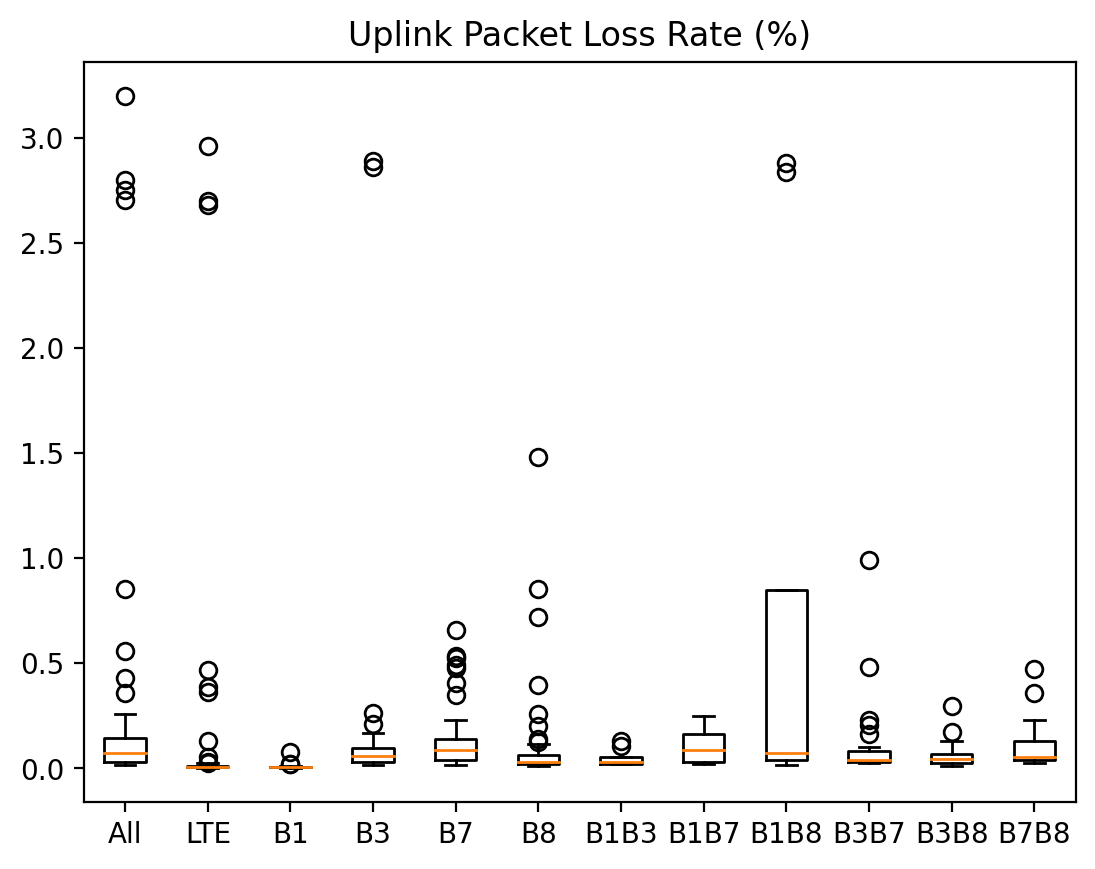

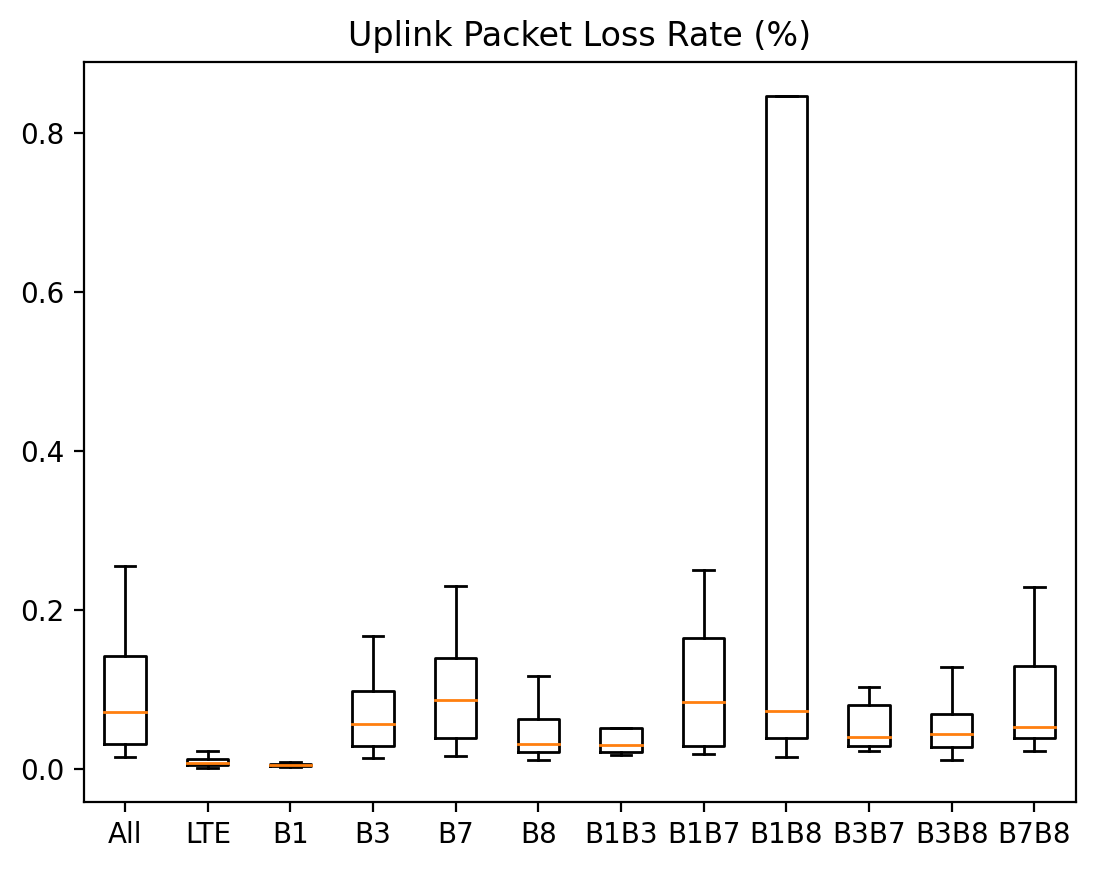

In [20]:
boxes = [DD[schm][1] for schm in schms]
labels = schms
plt.figure()
plt.boxplot(boxes, labels=labels, showfliers=True)
plt.title('Uplink Packet Loss Rate (%)')
plt.savefig(os.path.join('./temp', f'ul_plr_boxplot.png'), bbox_inches='tight', dpi=300)
plt.show()

boxes = [DD[schm][1] for schm in schms]
labels = schms
plt.figure()
plt.boxplot(boxes, labels=labels, showfliers=False)
plt.title('Uplink Packet Loss Rate (%)')
plt.savefig(os.path.join('./temp', f'ul_plr_boxplot_wo_outliers.png'), bbox_inches='tight', dpi=300)
plt.show()

### plot dl elr

In [24]:
# Downlink
DD = {key: [0, []] for key in schms}

for schm in schms:

    dl_files = dl_pkt_dict[schm]

    for dl_file in dl_files:

        df_dl = pd.read_pickle(dl_file)
        df_dl = set_data(df_dl)
        dlelr = df_dl[df_dl['lost'] == False].excl.mean() * 100
        
        print(round(dlelr, 2))
        
        DD[schm][0] += 1
        DD[schm][1].append(dlelr)
    #     break
    # break

0.25
0.34
0.22
0.39
0.73
0.41
0.34
0.41
0.45
0.71
0.24
0.68
0.24
0.45
0.24
0.11
0.34
0.53
0.14
0.46
0.24
0.5
0.07
0.47
0.11
0.37
0.31
0.53
0.35
0.33
4.02
0.61
1.9
0.58
0.43
0.85
0.36
0.43
0.9
0.49
0.7
1.06
0.9
0.3
0.43
0.23
0.86
0.49
0.94
0.91
0.11
0.83
0.23
0.29
0.59
0.76
1.09
1.16
1.38
0.2
0.23
0.95
0.1
2.46
0.7
0.63
0.16
0.75
0.08
0.24
0.41
0.2
0.81
0.86
0.7
0.37
1.95
0.57
2.1
1.36
1.25
0.08
0.17
1.08
0.91
1.6
0.91
1.27
0.47
0.9
0.9
0.34
0.38
1.15
1.34
1.26
1.08
0.91
2.44
0.25
1.57
0.16
1.47
0.4
0.27
0.11
0.16
0.37
0.69
0.5
0.02
0.95
0.17
0.86
0.02
0.12
0.04
2.69
0.07
1.22
0.23
0.76
0.49
0.75
0.17
0.19
0.48
0.82
0.16
0.32
0.21
0.15
0.32
0.03
1.51
0.64
0.55
0.48
0.15
0.6
0.72
0.43
0.31
0.49
0.45
0.7
0.27
1.02
0.55
0.55
0.74
0.53
0.75
0.48
0.42
1.17
0.24
0.36
0.4
0.31
0.39
0.53
0.65
0.3
0.34
0.29
0.3
0.68
0.15
0.28
0.08
0.38
0.45
0.43
0.64
0.22
0.09
0.77
0.43
0.3
0.42
0.34
0.36
0.28
0.89
0.32
0.61
0.78
0.4
0.86
0.94
0.62
0.21
0.61
0.52
0.75
0.76
0.89
0.85
0.54
0.88
1.13
0.72
0.9
1.12


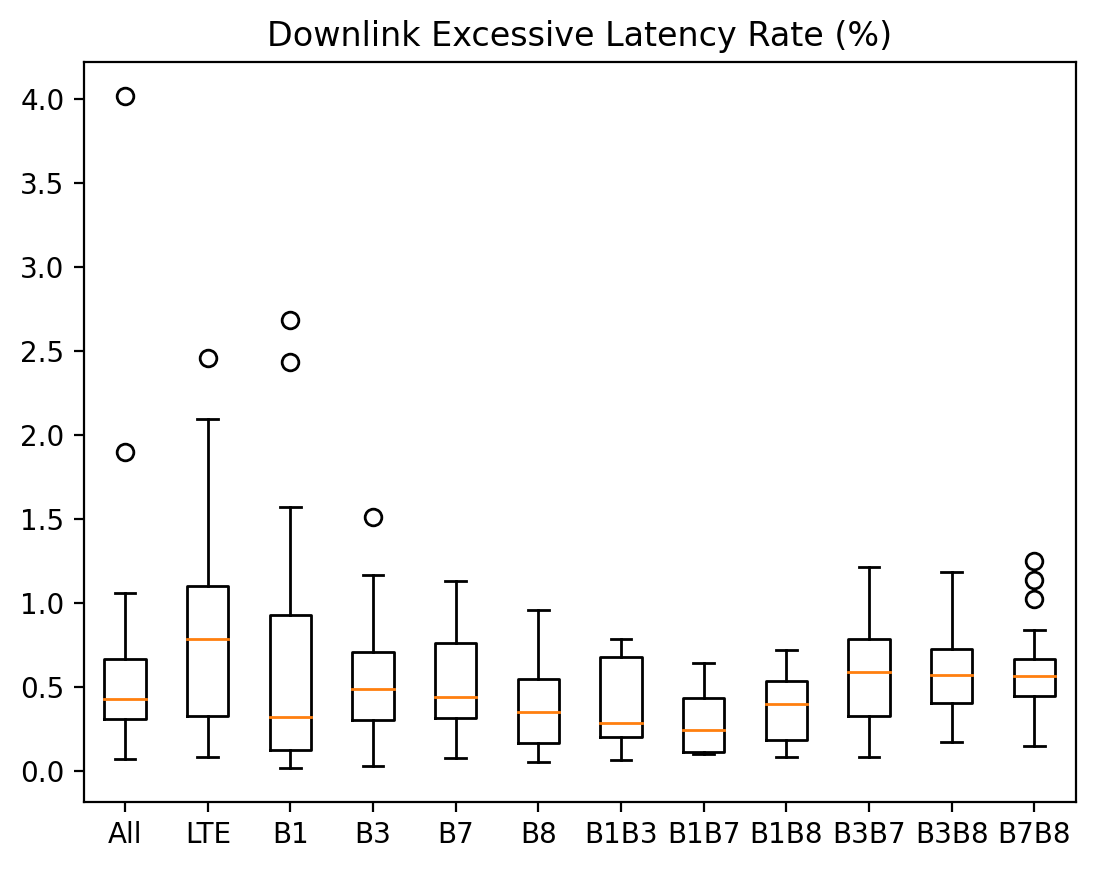

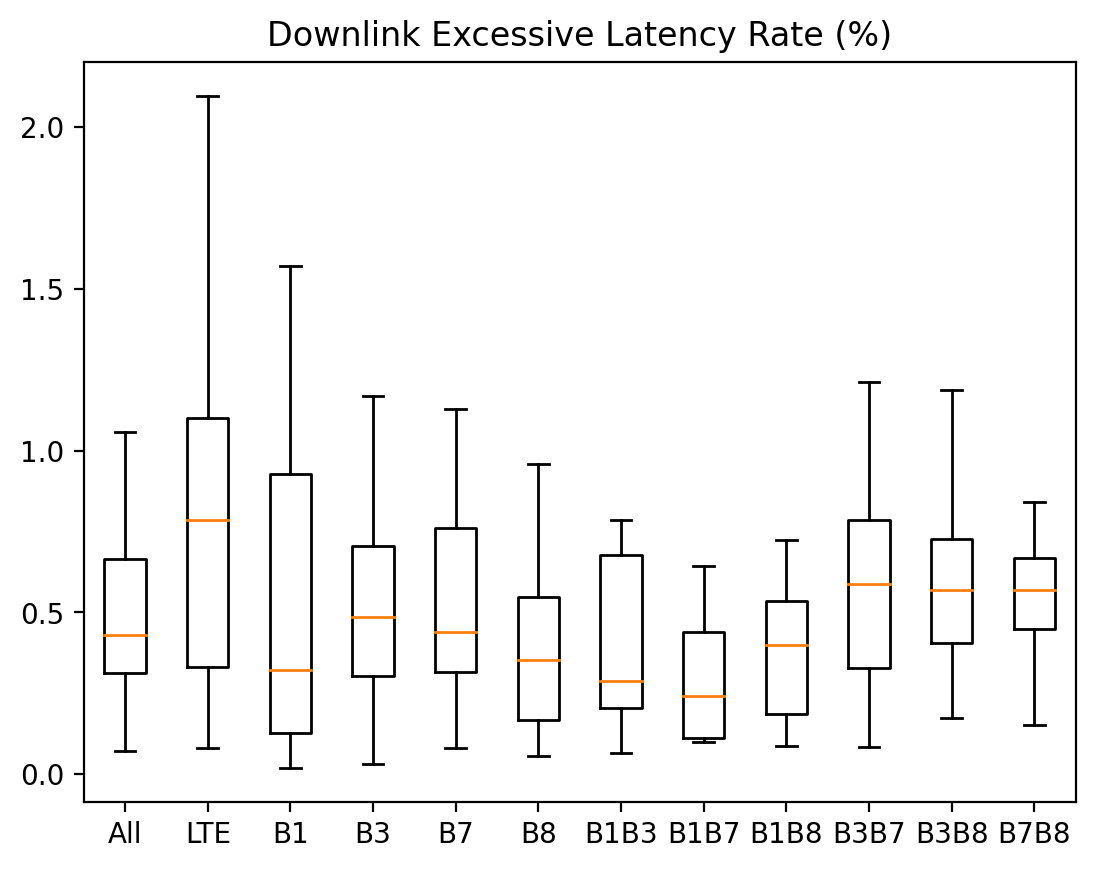

In [25]:
boxes = [DD[schm][1] for schm in schms]
labels = schms
plt.figure()
plt.boxplot(boxes, labels=labels, showfliers=True)
plt.title('Downlink Excessive Latency Rate (%)')
plt.savefig(os.path.join('./temp', f'dl_elr_boxplot.png'), bbox_inches='tight', dpi=300)
plt.show()

boxes = [DD[schm][1] for schm in schms]
labels = schms
plt.figure()
plt.boxplot(boxes, labels=labels, showfliers=False)
plt.title('Downlink Excessive Latency Rate (%)')
plt.savefig(os.path.join('./temp', f'dl_elr_boxplot_wo_outliers.png'), bbox_inches='tight', dpi=300)
plt.show()

### plot ul elr

In [26]:
# Uplink
DD = {key: [0, []] for key in schms}

for schm in schms:

    ul_files = ul_pkt_dict[schm]

    for ul_file in ul_files:

        df_ul = pd.read_pickle(ul_file)
        df_ul = set_data(df_ul)
        ulelr = df_ul[df_ul['lost'] == False].excl.mean() * 100
        
        print(round(ulelr, 2))
        
        DD[schm][0] += 1
        DD[schm][1].append(ulelr)
    #     break
    # break

0.39
1.64
0.29
1.8
0.42
0.25
0.02
0.98
15.2
2.2
0.46
12.42
0.2
2.82
0.13
1.28
0.27
1.91
3.65
2.43
0.15
3.67
0.6
0.41
0.39
3.1
0.42
0.74
0.75
0.57
3.14
4.44
1.84
0.86
0.75
4.2
0.33
1.77
0.69
1.71
1.32
2.99
1.26
1.02
0.24
2.04
0.65
1.73
0.9
1.74
0.07
0.96
0.15
1.4
0.99
0.91
2.3
1.49
1.31
1.52
0.37
3.56
0.97
3.07
0.74
0.76
0.21
0.15
0.1
0.71
0.41
1.06
0.78
1.56
0.61
0.12
0.53
0.72
0.85
1.3
0.71
0.04
0.78
1.58
0.86
2.12
0.58
2.49
0.9
0.62
0.78
0.7
0.08
0.35
0.79
1.53
0.65
0.98
1.7
0.01
0.01
0.02
0.14
0.01
0.01
0.53
0.69
1.37
0.04
0.52
0.0
0.88
0.01
1.64
0.0
1.13
0.0
0.94
0.02
6.2
0.16
0.34
0.52
100.0
0.0
0.75
0.09
0.62
0.37
0.58
0.73
0.4
0.51
1.58
1.03
2.27
1.12
4.92
0.55
2.19
3.67
17.23
0.29
2.61
5.22
11.79
2.43
4.1
9.45
3.25
2.47
11.24
0.45
4.19
10.07
4.26
0.13
0.55
0.4
0.46
3.81
3.11
0.51
2.48
4.29
2.49
1.46
4.02
0.31
0.49
0.43
100.0
0.14
1.68
0.35
16.55
0.8
6.15
1.03
6.41
0.19
0.68
0.56
3.28
2.32
3.77
0.84
17.79
1.07
2.56
0.76
18.08
0.17
2.98
6.8
10.38
2.38
3.48
9.27
2.95
4.8
6.5
0.37


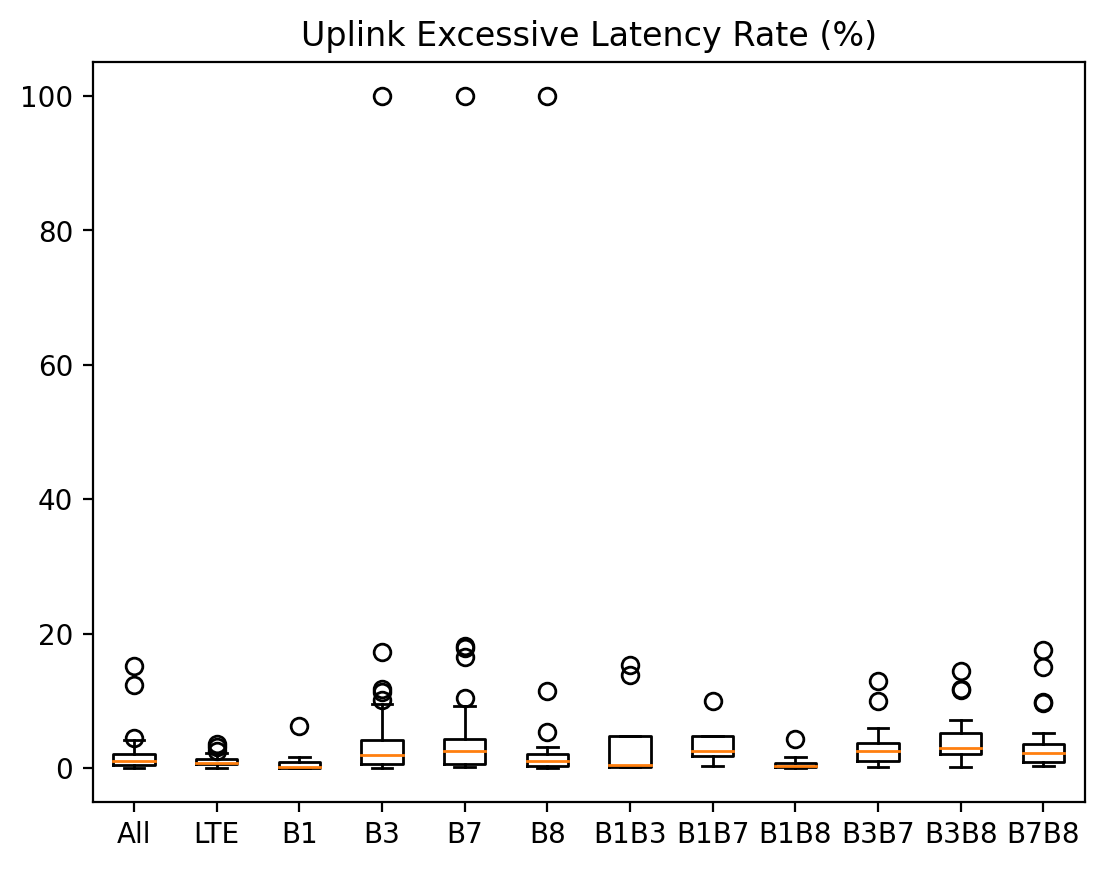

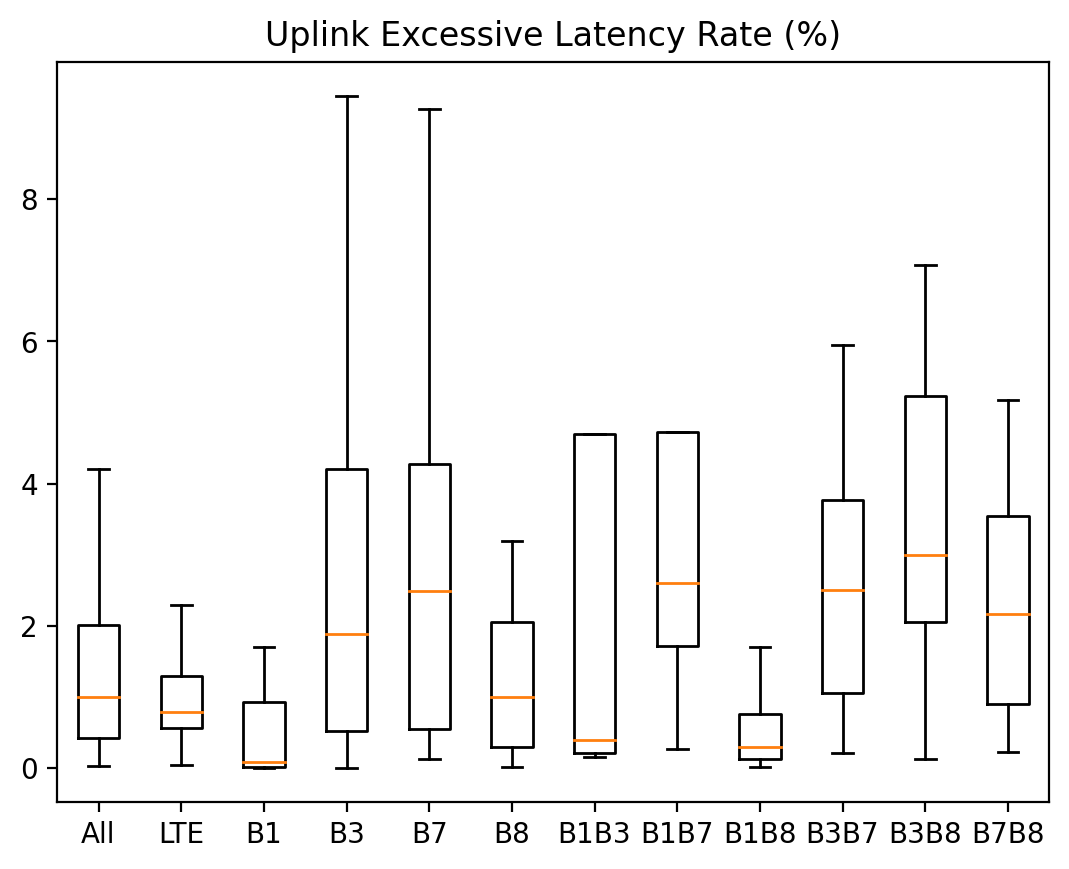

In [27]:
boxes = [DD[schm][1] for schm in schms]
labels = schms
plt.figure()
plt.boxplot(boxes, labels=labels, showfliers=True)
plt.title('Uplink Excessive Latency Rate (%)')
plt.savefig(os.path.join('./temp', f'ul_elr_boxplot.png'), bbox_inches='tight', dpi=300)
plt.show()

boxes = [DD[schm][1] for schm in schms]
labels = schms
plt.figure()
plt.boxplot(boxes, labels=labels, showfliers=False)
plt.title('Uplink Excessive Latency Rate (%)')
plt.savefig(os.path.join('./temp', f'ul_elr_boxplot_wo_outliers.png'), bbox_inches='tight', dpi=300)
plt.show()

## Handover Counts

In [56]:
pdir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # for jupyter-notebook
sys.path.insert(1, pdir)
from myutils import *

handover1 = ['LTE_HO','MN_HO','SN_HO','SN_Setup','SN_Rel','SN_Rel_MN_HO',
             'SCG_Failure','MCG_Failure','NAS_Recovery',]

handover2 = ['LTE_HO','MN_HO','SN_HO','SN_Setup','SN_Rel','SN_Rel_MN_HO',
             'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)','SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
             'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
             'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

handover3 = ['LTE_HO','NR_HO','RLF','NR_Setup']

In [49]:
table = pd.DataFrame(columns=[*handover1, 'rounds'])

for key, lst in rrc_dict.items():
    
    ho_dict = {k:0 for k in handover1}
    
    for path in lst:
        
        df = pd.read_pickle(os.path.join(os.path.dirname(path), 'handover_info_list.pkl'))

        for tag in handover1:
            ho_dict[tag] += sum(df['ho_type'] == tag)
    
    new_row = pd.DataFrame(ho_dict, index=[key])
    table = pd.concat([table, new_row])
    table.at[key, 'rounds'] = len(lst)

In [52]:
table1 = table.copy()
for tag in handover1:
    table1[tag] = table1[tag].astype('float64')
    table1[tag] = table1[tag] / (table1['rounds'] + 1e-9)
    table1[tag] = table1[tag].apply(lambda x: round(x, 2))
display(table)
display(table1)

,LTE_HO,MN_HO,SN_HO,SN_Setup,SN_Rel,SN_Rel_MN_HO,SCG_Failure,MCG_Failure,NAS_Recovery,rounds
All,1,738,834,207,6,124,3,90,0,50
LTE,847,0,0,0,0,0,0,42,0,48
B1,346,0,0,0,0,0,0,16,3,22
B3,3,459,615,147,4,90,4,65,2,36
B7,16,811,802,273,10,146,11,135,2,50
B8,2,973,828,140,7,95,6,36,3,48
B1B3,0,87,142,32,1,19,0,12,0,8
B1B7,0,74,70,22,0,8,0,11,0,4
B1B8,2,143,152,20,1,10,1,5,1,8
B3B7,1,324,434,95,1,50,2,49,1,26


,LTE_HO,MN_HO,SN_HO,SN_Setup,SN_Rel,SN_Rel_MN_HO,SCG_Failure,MCG_Failure,NAS_Recovery,rounds
All,0.02,14.76,16.68,4.14,0.12,2.48,0.06,1.80,0.00,50
LTE,17.65,0.00,0.00,0.00,0.00,0.00,0.00,0.87,0.00,48
B1,15.73,0.00,0.00,0.00,0.00,0.00,0.00,0.73,0.14,22
B3,0.08,12.75,17.08,4.08,0.11,2.50,0.11,1.81,0.06,36
B7,0.32,16.22,16.04,5.46,0.20,2.92,0.22,2.70,0.04,50
B8,0.04,20.27,17.25,2.92,0.15,1.98,0.12,0.75,0.06,48
B1B3,0.00,10.87,17.75,4.00,0.12,2.37,0.00,1.50,0.00,8
B1B7,0.00,18.50,17.50,5.50,0.00,2.00,0.00,2.75,0.00,4
B1B8,0.25,17.87,19.00,2.50,0.12,1.25,0.12,0.62,0.12,8
B3B7,0.04,12.46,16.69,3.65,0.04,1.92,0.08,1.88,0.04,26


In [53]:
table = pd.DataFrame(columns=[*handover2, 'rounds'])

for key, lst in rrc_dict.items():
    
    ho_dict = {k:0 for k in handover2}
    
    for path in lst:
        
        df = pd.read_pickle(os.path.join(os.path.dirname(path), 'handover_info_list.pkl'))

        for tag in handover2:
            ho_dict[tag] += sum(df['ho_type0'] == tag)
    
    new_row = pd.DataFrame(ho_dict, index=[key])
    table = pd.concat([table, new_row])
    table.at[key, 'rounds'] = len(lst)

In [55]:
table1 = table.copy()
for tag in handover2:
    table1[tag] = table1[tag].astype('float64')
    table1[tag] = table1[tag] / (table1['rounds'] + 1e-9)
    table1[tag] = table1[tag].apply(lambda x: round(x, 2))
display(table)
display(table1)

,LTE_HO,MN_HO,SN_HO,SN_Setup,SN_Rel,SN_Rel_MN_HO,SCG_Failure_t310-Expiry (0),SCG_Failure_randomAccessProblem (1),SCG_Failure_rlc-MaxNumRetx (2),SCG_Failure_synchReconfigFailureSCG (3),SCG_Failure_scg-ReconfigFailure (4),SCG_Failure_srb3-IntegrityFailure (5),SCG_Failure_other-r16 (6),MCG_Failure_reconfigurationFailure (0),MCG_Failure_handoverFailure (1),MCG_Failure_otherFailure (2),NAS_Recovery_reconfigurationFailure (0),NAS_Recovery_handoverFailure (1),NAS_Recovery_otherFailure (2),rounds
All,1,738,834,207,6,124,0,0,0,3,0,0,0,0,0,90,0,0,0,50
LTE,847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,48
B1,346,0,0,0,0,0,0,0,0,0,0,0,0,0,5,11,0,0,3,22
B3,3,459,615,147,4,90,0,0,0,4,0,0,0,0,1,64,0,1,1,36
B7,16,811,802,273,10,146,3,2,2,4,0,0,0,0,4,131,0,0,2,50
B8,2,973,828,140,7,95,1,1,0,4,0,0,0,0,6,30,0,0,3,48
B1B3,0,87,142,32,1,19,0,0,0,0,0,0,0,0,0,12,0,0,0,8
B1B7,0,74,70,22,0,8,0,0,0,0,0,0,0,0,1,10,0,0,0,4
B1B8,2,143,152,20,1,10,0,0,0,1,0,0,0,0,0,5,0,0,1,8
B3B7,1,324,434,95,1,50,1,1,0,0,0,0,0,0,0,49,0,0,1,26


,LTE_HO,MN_HO,SN_HO,SN_Setup,SN_Rel,SN_Rel_MN_HO,SCG_Failure_t310-Expiry (0),SCG_Failure_randomAccessProblem (1),SCG_Failure_rlc-MaxNumRetx (2),SCG_Failure_synchReconfigFailureSCG (3),SCG_Failure_scg-ReconfigFailure (4),SCG_Failure_srb3-IntegrityFailure (5),SCG_Failure_other-r16 (6),MCG_Failure_reconfigurationFailure (0),MCG_Failure_handoverFailure (1),MCG_Failure_otherFailure (2),NAS_Recovery_reconfigurationFailure (0),NAS_Recovery_handoverFailure (1),NAS_Recovery_otherFailure (2),rounds
All,0.02,14.76,16.68,4.14,0.12,2.48,0.00,0.00,0.00,0.06,0.0,0.0,0.0,0.0,0.00,1.80,0.0,0.00,0.00,50
LTE,17.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.87,0.0,0.00,0.00,48
B1,15.73,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.23,0.50,0.0,0.00,0.14,22
B3,0.08,12.75,17.08,4.08,0.11,2.50,0.00,0.00,0.00,0.11,0.0,0.0,0.0,0.0,0.03,1.78,0.0,0.03,0.03,36
B7,0.32,16.22,16.04,5.46,0.20,2.92,0.06,0.04,0.04,0.08,0.0,0.0,0.0,0.0,0.08,2.62,0.0,0.00,0.04,50
B8,0.04,20.27,17.25,2.92,0.15,1.98,0.02,0.02,0.00,0.08,0.0,0.0,0.0,0.0,0.12,0.62,0.0,0.00,0.06,48
B1B3,0.00,10.87,17.75,4.00,0.12,2.37,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,1.50,0.0,0.00,0.00,8
B1B7,0.00,18.50,17.50,5.50,0.00,2.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.25,2.50,0.0,0.00,0.00,4
B1B8,0.25,17.87,19.00,2.50,0.12,1.25,0.00,0.00,0.00,0.12,0.0,0.0,0.0,0.0,0.00,0.62,0.0,0.00,0.12,8
B3B7,0.04,12.46,16.69,3.65,0.04,1.92,0.04,0.04,0.00,0.00,0.0,0.0,0.0,0.0,0.00,1.88,0.0,0.00,0.04,26


In [61]:
table = pd.DataFrame(columns=[*handover3, 'rounds'])

for key, lst in rrc_dict.items():
    
    ho_dict = {k:0 for k in handover3}
    
    for path in lst:
        
        df = pd.read_pickle(os.path.join(os.path.dirname(path), 'handover_info_list.pkl'))

        for tag in handover1:
            tag1 = tag
            ### re-classify
            if tag in ['LTE_HO','MN_HO','SN_Rel_MN_HO']:
                tag = 'LTE_HO'
            elif tag in ['SN_HO','SN_Rel']:
                tag = 'NR_HO'
            elif tag in ['SCG_Failure','MCG_Failure','NAS_Recovery']:
                tag = 'RLF'
            elif tag in ['SN_Setup']:
                tag = 'NR_Setup'
            else:
                pass
            ho_dict[tag] += sum(df['ho_type'] == tag1)
    
    new_row = pd.DataFrame(ho_dict, index=[key])
    table = pd.concat([table, new_row])
    table.at[key, 'rounds'] = len(lst)

In [62]:
table1 = table.copy()
for tag in handover3:
    table1[tag] = table1[tag].astype('float64')
    table1[tag] = table1[tag] / (table1['rounds'] + 1e-9)
    table1[tag] = table1[tag].apply(lambda x: round(x, 2))
display(table)
display(table1)

,LTE_HO,NR_HO,RLF,NR_Setup,rounds
All,863,840,93,207,50
LTE,847,0,42,0,48
B1,346,0,19,0,22
B3,552,619,71,147,36
B7,973,812,148,273,50
B8,1070,835,45,140,48
B1B3,106,143,12,32,8
B1B7,82,70,11,22,4
B1B8,155,153,7,20,8
B3B7,375,435,52,95,26


,LTE_HO,NR_HO,RLF,NR_Setup,rounds
All,17.26,16.80,1.86,4.14,50
LTE,17.65,0.00,0.87,0.00,48
B1,15.73,0.00,0.86,0.00,22
B3,15.33,17.19,1.97,4.08,36
B7,19.46,16.24,2.96,5.46,50
B8,22.29,17.40,0.94,2.92,48
B1B3,13.25,17.87,1.50,4.00,8
B1B7,20.50,17.50,2.75,5.50,4
B1B8,19.37,19.12,0.87,2.50,8
B3B7,14.42,16.73,2.00,3.65,26


## Evaluate Performance

In [65]:
DD = {key: [0, [], [], [], []] for key in schms}
Overall = [0, [], []]

for schm in schms:

    dl_files = dl_pkt_dict[schm]
    ul_files = ul_pkt_dict[schm]

    for dl_file in dl_files:

        df_dl = pd.read_pickle(dl_file)
        df_dl = set_data(df_dl)
        dlplr = df_dl.lost.mean() * 100
        
        # print(round(dlplr, 2))
        
        DD[schm][0] += 1
        DD[schm][1].append(dlplr)
        DD[schm][3].append(dl_file)
        Overall[0] += 1
        Overall[1].append(dlplr)

    for ul_file in ul_files:

        df_ul = pd.read_pickle(ul_file)
        df_ul = set_data(df_ul)
        ulplr = df_ul.lost.mean() * 100
        
        # print(round(ulplr, 2))
        
        DD[schm][2].append(ulplr)
        DD[schm][4].append(ul_file)
        Overall[2].append(ulplr)

# pprint(DD)
# print(Overall)

In [73]:
dl_plrs = sorted(Overall[1])
dl_upper_thr = np.percentile(dl_plrs, 75)
dl_lower_thr = np.percentile(dl_plrs, 25)
print('dl threshold (%):', round(dl_lower_thr, 3), round(dl_upper_thr, 3))

ul_plrs = sorted(Overall[2])
ul_upper_thr = np.percentile(ul_plrs, 75)
ul_lower_thr = np.percentile(ul_plrs, 25)
print('ul threshold (%):', round(ul_lower_thr, 3), round(ul_upper_thr, 3))

dl threshold (%): 0.212 1.041
ul threshold (%): 0.022 0.103


In [85]:
# table = pd.DataFrame(columns=[0, 'dl.O', 'ul.O', 'dl.∆', 'ul.∆', 'dl.X', 'ul.X', 'total'])
table = pd.DataFrame(columns=['dl.O', 'ul.O', 'dl.∆', 'ul.∆', 'dl.X', 'ul.X', 'total'])
for schm in schms:
    total = DD[schm][0]
    print(schm, total)
    dl_O, ul_O, dl_M, ul_M, dl_X, ul_X = 0, 0, 0, 0, 0, 0
    for dl_plr, ul_plr, dl_file, ul_file in zip(DD[schm][1], DD[schm][2], DD[schm][3], DD[schm][4]):
        dl_flag = 'O' if dl_plr < dl_lower_thr else 'X' if dl_plr > dl_upper_thr else '∆'
        ul_flag = 'O' if ul_plr < ul_lower_thr else 'X' if ul_plr > ul_upper_thr else '∆'
        if dl_flag == 'X' or ul_flag == 'X':
            print(dl_flag, round(dl_plr, 3), dl_file)
            print(ul_flag, round(ul_plr, 3), ul_file)
        if dl_flag == 'O': dl_O += 1
        if ul_flag == 'O': ul_O += 1
        if dl_flag == '∆': dl_M += 1
        if ul_flag == '∆': ul_M += 1
        if dl_flag == 'X': dl_X += 1
        if ul_flag == 'X': ul_X += 1
    table.loc[schm] = [dl_O, ul_O, dl_M, ul_M, dl_X, ul_X, total]
# table = table.set_index(0).T

table1 = table.copy()
for col in ['dl.O', 'ul.O', 'dl.∆', 'ul.∆', 'dl.X', 'ul.X']:
    table1[col] = table1[col].astype('float64')
    table1[col] = table1[col] / (table1['total'] + 1e-9)
    table1[col] = table1[col].apply(lambda x: round(x, 2))
display(table)
display(table1)

All 50
∆ 0.415 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#02/data/udp_dnlk_loss_latency.pkl
X 0.105 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#02/data/udp_uplk_loss_latency.pkl
∆ 1.015 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment1/qc03/#01/data/udp_dnlk_loss_latency.pkl
X 0.556 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment1/qc03/#01/data/udp_uplk_loss_latency.pkl
O 0.131 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment1/qc03/#02/data/udp_dnlk_loss_latency.pkl
X 0.133 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment1/qc03/#02/data/udp_uplk_loss_latency.pkl
X 1.943 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment3/qc01/#02/data/udp_dnlk_loss_latency.pkl
X 0.146 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment3/qc01/#02/data/udp_uplk_loss_latency.pkl
X 1.692 /Users/jackbedford/Desktop/MO

,dl.O,ul.O,dl.∆,ul.∆,dl.X,ul.X,total
All,6,5,29,24,15,21,50
LTE,35,37,11,4,2,7,48
B1,13,19,9,3,0,0,22
B3,4,5,22,22,10,9,36
B7,3,2,21,29,26,19,50
B8,15,12,26,27,7,9,48
B1B3,2,3,4,3,2,2,8
B1B7,1,1,1,1,2,2,4
B1B8,2,1,5,4,1,3,8
B3B7,3,0,14,21,9,5,26


,dl.O,ul.O,dl.∆,ul.∆,dl.X,ul.X,total
All,0.12,0.10,0.58,0.48,0.30,0.42,50
LTE,0.73,0.77,0.23,0.08,0.04,0.15,48
B1,0.59,0.86,0.41,0.14,0.00,0.00,22
B3,0.11,0.14,0.61,0.61,0.28,0.25,36
B7,0.06,0.04,0.42,0.58,0.52,0.38,50
B8,0.31,0.25,0.54,0.56,0.15,0.19,48
B1B3,0.25,0.37,0.50,0.37,0.25,0.25,8
B1B7,0.25,0.25,0.25,0.25,0.50,0.50,4
B1B8,0.25,0.12,0.62,0.50,0.12,0.37,8
B3B7,0.12,0.00,0.54,0.81,0.35,0.19,26
